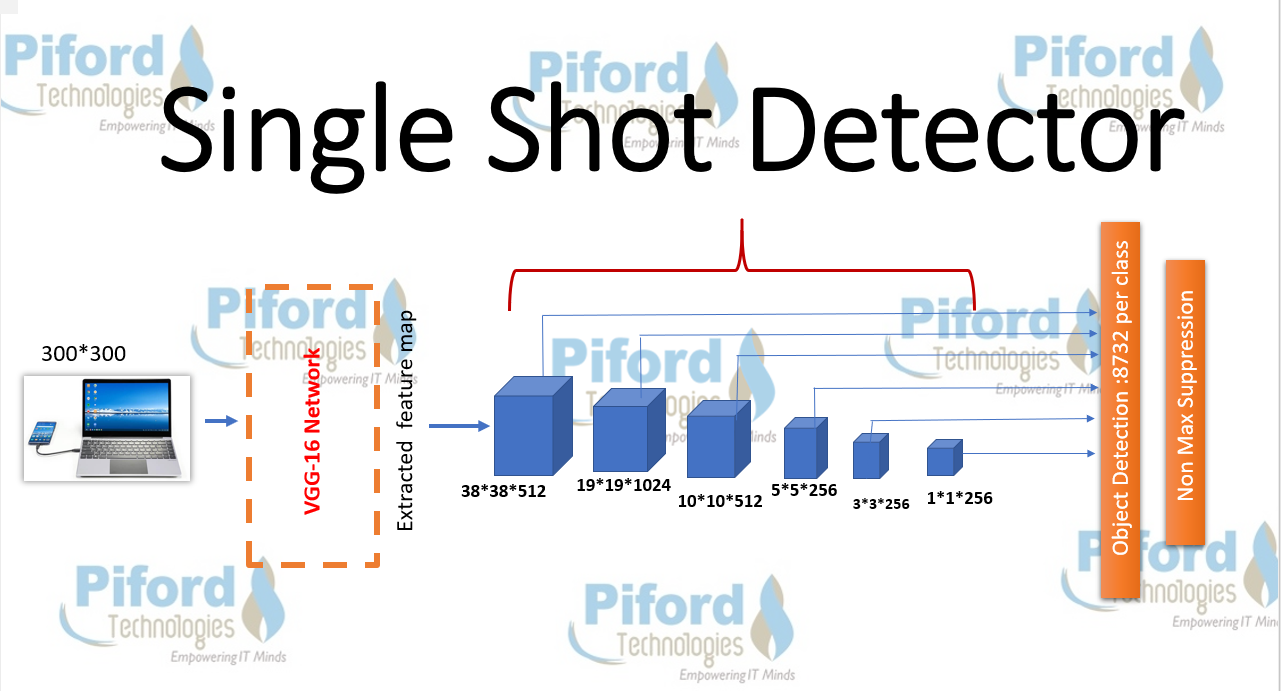

In [1]:
from __future__ import division
import numpy as np
from keras.models import Model
from keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate
from keras.regularizers import l2
import keras.backend as K

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections



Using TensorFlow backend.


In [7]:
image_size=(300,300,3)
n_classes = 20
mean_color = [123, 117, 104] 
swap_channels = [2, 1, 0] #BGR instead of RGB
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] 
scales = scales_pascal
two_boxes_for_ar1 = True 
steps = [8, 16, 32, 64, 100, 300] 
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] 
clip_boxes = False 
variances = [0.1, 0.1, 0.2, 0.2] 
normalize_coords = True

def ssd_300(image_size,
            n_classes,
            l2_regularization=0.0005,  # by default it is 20
            scales=None,
            aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5]],
            two_boxes_for_ar1=True,
            steps=[8, 16, 32, 64, 100, 300],
            offsets=None,
            clip_boxes=False,
            variances=[0.1, 0.1, 0.2, 0.2],
            coords='centroids',
            normalize_coords=True,
            subtract_mean=[123, 117, 104],
            divide_by_stddev=None,
            swap_channels=[2, 1, 0],
            confidence_thresh=0.01,
            iou_threshold=0.45,
            top_k=200,
            nms_max_output_size=400,
            return_predictor_sizes=False):

    n_predictor_layers = 6 # The number of predictor conv layers 
    n_classes += 1 # for background class
    l2_reg = l2_regularization # Make the internal name shorter.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

   
    # Build the network

    x = Input(shape=(img_height, img_width, img_channels))

    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_1')(x)
    conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_2')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)
    print("Size after 1st block: ",conv1_2)

    conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_1')(pool1)
    conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_2')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)
    print("Size after 2nd block: ",conv2_2)
    
    conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_1')(pool2)
    conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)
    print("Size after 3rd block: ",conv3_3)
    
    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_1')(pool3)
    conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)
    print("Size after 4th block: ",conv4_3)

    conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_1')(pool4)
    conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='pool5')(conv5_3)
    print("Size after 5th block: ",conv5_3)
    
    fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)
    print("Size after 1st fc layer: ",fc6)
    
    fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)
    print("Size after 2nd fc layer: ",fc7)

    # The final output of the base network is a feature map of size 19 x 19 x 1024.
   
    # Feed conv4_3 into the L2 normalization layer
    conv4_3_norm = L2Normalization(gamma_init=20, name='conv4_3_norm')(conv4_3)

   
    # 6 predictor layers : Task is to predict classification score and bounding bounding

    # Output:  `(batch, height, width, n_boxes * n_classes)`
    conv4_3_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal',
                                    kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(conv4_3_norm)
    fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', 
                           kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
    conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal',
                               kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv3_2)
    conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', 
                               kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv4_2)
    conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal',
                               kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv5_2)
    conv9_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal',
                               kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv6_2)
   

    # predict 4 box coordinates for each box, 
    # Output: (batch, height, width, n_boxes * 4)
    conv4_3_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_loc')(conv4_3_norm)
    fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
    conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
    conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
    conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
    conv9_2_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_loc')(conv9_2)

    
    
    ### Generate the anchor boxes 

    # Output shape of anchors: `(batch, height, width, n_boxes, 8)`
    # 8 = the four anchor box coordinates and the four variance values for each box.
    conv4_3_norm_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                                             two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0], clip_boxes=clip_boxes,
                                             variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv4_3_norm_mbox_priorbox')(conv4_3_norm_mbox_loc)
    fc7_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                                    two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1], clip_boxes=clip_boxes,
                                    variances=variances, coords=coords, normalize_coords=normalize_coords, name='fc7_mbox_priorbox')(fc7_mbox_loc)
    conv6_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv6_2_mbox_priorbox')(conv6_2_mbox_loc)
    conv7_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv7_2_mbox_priorbox')(conv7_2_mbox_loc)
    conv8_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[4], next_scale=scales[5], aspect_ratios=aspect_ratios[4],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[4], this_offsets=offsets[4], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv8_2_mbox_priorbox')(conv8_2_mbox_loc)
    conv9_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[5], next_scale=scales[6], aspect_ratios=aspect_ratios[5],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[5], this_offsets=offsets[5], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv9_2_mbox_priorbox')(conv9_2_mbox_loc)

    # Reshape the class prediction in such a way so that we can have classes at last axis to perform Softmax on them
    # Reshape the class predictions in this format : (batch, height * width * n_boxes, n_classes)
    conv4_3_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
    fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
    conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
    conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
    conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
    conv9_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)
    
    # Reshape the box predictions in such a way so that we can have bounding box cordinates at last axis to calculate the Loss
    # This is the desired shape: (batch, height * width * n_boxes, 4)`

    conv4_3_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_3_norm_mbox_loc)
    fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
    conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
    conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
    conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
    conv9_2_mbox_loc_reshape = Reshape((-1, 4), name='conv9_2_mbox_loc_reshape')(conv9_2_mbox_loc)
    
    # Reshape the anchor box tensors to (batch, height * width * n_boxes, 8)`
    conv4_3_norm_mbox_priorbox_reshape = Reshape((-1, 8), name='conv4_3_norm_mbox_priorbox_reshape')(conv4_3_norm_mbox_priorbox)
    fc7_mbox_priorbox_reshape = Reshape((-1, 8), name='fc7_mbox_priorbox_reshape')(fc7_mbox_priorbox)
    conv6_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv6_2_mbox_priorbox_reshape')(conv6_2_mbox_priorbox)
    conv7_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv7_2_mbox_priorbox_reshape')(conv7_2_mbox_priorbox)
    conv8_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv8_2_mbox_priorbox_reshape')(conv8_2_mbox_priorbox)
    conv9_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv9_2_mbox_priorbox_reshape')(conv9_2_mbox_priorbox)

    ### Concatenate the predictions from 6 predictor layers

    # n_classes
    mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])

    # Bounding boxes`: (batch, n_boxes_total, 4)
    mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_3_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     conv9_2_mbox_loc_reshape])

    # Anchor boxes`: (batch, n_boxes_total, 8)
    mbox_priorbox = Concatenate(axis=1, name='mbox_priorbox')([conv4_3_norm_mbox_priorbox_reshape,
                                                               fc7_mbox_priorbox_reshape,
                                                               conv6_2_mbox_priorbox_reshape,
                                                               conv7_2_mbox_priorbox_reshape,
                                                               conv8_2_mbox_priorbox_reshape,
                                                               conv9_2_mbox_priorbox_reshape])

    # The box coordinate predictions will go into the loss function just the way they are,
    # but for the class predictions, we'll apply a softmax activation layer first
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)

    # Concatenate the class and box predictions and the anchors to one large predictions vector
    # Output shape of `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    predictions = Concatenate(axis=2, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_priorbox])

  
    model = Model(inputs=x, outputs=predictions)

    return model
